# Processing for Manifest ⭐

## Imports

In [7]:
import pandas as pd
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import json


## AudioSet Ontology

### Loading ontology and making Heirarchy

In [1]:
import json
import pandas as pd

ontology_file_path = '/disk1/audioset/annotations/ontology.json'
mid_to_label_file_path = '/disk1/audioset/annotations/mid_to_display_name.tsv'

# Read the mid-to-label mapping
mid_to_label = pd.read_csv(mid_to_label_file_path, sep='\t', names=['mid', 'label'])
mid_to_label = mid_to_label.set_index('mid').to_dict()['label']
label_to_mid = {v: k for k, v in mid_to_label.items()}

# Load the ontology data
with open(ontology_file_path) as f:
    ontology_data = json.load(f)

# Create a dictionary to store the hierarchy
hierarchy = {}
for item in ontology_data:
    hierarchy[item['id']] = {
        'name': item['name'],
        'children': item.get('child_ids', [])
    }

# Function to recursively print the hierarchy with tree-like structure
def print_hierarchy(node_id, prefix='', is_last=True):
    node = hierarchy[node_id]
    connector = '└── ' if is_last else '├── '
    print(prefix + connector + f"{node_id}: {node['name']}")
    prefix += '    ' if is_last else '│   '
    for i, child_id in enumerate(node['children']):
        is_last_child = (i == len(node['children']) - 1)
        print_hierarchy(child_id, prefix, is_last_child)

# Find the root nodes (nodes without parents)
root_nodes = set(hierarchy.keys())
for item in ontology_data:
    for child_id in item.get('child_ids', []):
        if child_id in root_nodes:
            root_nodes.remove(child_id)

# Print the hierarchy starting from each root node
for root_id in sorted(root_nodes):
    print_hierarchy(root_id)


└── /m/04rlf: Music
    ├── /m/04szw: Musical instrument
    │   ├── /m/0fx80y: Plucked string instrument
    │   │   ├── /m/0342h: Guitar
    │   │   │   ├── /m/02sgy: Electric guitar
    │   │   │   ├── /m/018vs: Bass guitar
    │   │   │   ├── /m/042v_gx: Acoustic guitar
    │   │   │   ├── /m/06w87: Steel guitar, slide guitar
    │   │   │   ├── /m/01glhc: Tapping (guitar technique)
    │   │   │   └── /m/07s0s5r: Strum
    │   │   ├── /m/018j2: Banjo
    │   │   ├── /m/0jtg0: Sitar
    │   │   ├── /m/04rzd: Mandolin
    │   │   ├── /m/01bns_: Zither
    │   │   └── /m/07xzm: Ukulele
    │   ├── /m/05148p4: Keyboard (musical)
    │   │   ├── /m/05r5c: Piano
    │   │   │   └── /m/01s0ps: Electric piano
    │   │   │       ├── /m/025cbm: Clavinet
    │   │   │       └── /m/0bxl5: Rhodes piano
    │   │   ├── /m/013y1f: Organ
    │   │   │   ├── /m/03xq_f: Electronic organ
    │   │   │   └── /m/03gvt: Hammond organ
    │   │   ├── /m/0l14qv: Synthesizer
    │   │   │   ├── /m/01v1d8

### Function for getting all children, useful for list of labels to be avoided(never consider videos) and for find all child nodes function.

In [2]:
def get_all_children(node_id):
    node = hierarchy[node_id]
    nodes = [(node_id, node['name'])]
    for child_id in node['children']:
        nodes.extend(get_all_children(child_id))
    return nodes

# ids = ["/m/0l14jd", "/m/0kpv1t", "/m/074ft", "/m/09l8g", "/t/dd00089"] # with human voice
ids = ["/m/0l14jd", "/m/0kpv1t", "/m/074ft", "/m/09x0r", "/m/02rtxlg","/m/015lz1", "/t/dd00089"]
ids_to_be_avoided = []
for id in ids:
    # print(f"###################################Children of {id}:")
    for child_id, child_name in get_all_children(id):
        # print(f"  {child_id}: {child_name}")
        ids_to_be_avoided.append(child_id)


### find_child_most_nodes given labels, not useful currently. Ref:[notion](https://www.notion.so/whissle/Notes-689a8cbc99b142ce84de0ffab2ed5800?pvs=4#8221c59473e44f728a573c438e5391b0)

In [3]:

def find_child_most_nodes(labels):
    child_most_labels = set()
    
    def has_children_in_labels(node_id, labels):
        if node_id in hierarchy.keys():
            for child_id in hierarchy[node_id]['children']:
                if child_id in labels or has_children_in_labels(child_id, labels):
                    return True
            return False
        else:
            return node_id in labels
    
    for label in labels:
        if not has_children_in_labels(label, labels):
            child_most_labels.add(label)
    
    return list(child_most_labels)

# Example usage
labels = ['/t/dd00123', '/m/07bm98', '/m/04zc0', '/t/dd00122']
child_most_nodes = find_child_most_nodes(labels)
print("Child Most Nodes:")
print(child_most_nodes)


Child Most Nodes:
['/m/04zc0', '/t/dd00122']


## SPLIT TYPE

In [20]:
split_type = 'eval'

## Code to Filter out non speech video segement from the actual audioset strong annotations

In [5]:
# Load the TSV file
# Replace 'your_file.tsv' with the path to your TSV file
df = pd.read_csv(f'/disk1/audioset/annotations/audioset_{split_type}_strong.tsv', sep='\t')

# Function to extract YouTube ID and start time
def extract_ytid_and_start(segment_id):
    ytid, startimems = segment_id.rsplit('_', 1)
    start_seconds = int(startimems) / 1000.0
    return ytid, start_seconds

mid_to_label = pd.read_csv('/disk1/audioset/annotations/mid_to_display_name.tsv', sep='\t', names=['mid', 'label'])
# Apply the function to extract YTID and start_seconds
df['YTID'], df['start_seconds'] = zip(*df['segment_id'].map(extract_ytid_and_start))

# Calculate end_seconds from start_seconds
df['end_seconds'] = df['start_seconds'] + 10.0

# Group by YTID, start_seconds, and end_seconds and aggregate labels
# get only child most labels
# df['label'] = df['label'].apply(lambda x: find_child_most_nodes(x.split(',')))
# df['label'] = df['label'].apply(lambda x: ','.join(x))
# Group by YTID, start_seconds, and end_seconds and aggregate labels
result = df.groupby(['YTID', 'start_seconds', 'end_seconds'])['label'].apply(lambda x: ',"' + ','.join(x) + '"').reset_index()

# ids_to_be_avoided = ['/m/02zsn','/m/05zppz','/m/07qfr4h','/m/09x0r','/m/0brhx','/m/0ytgt','/t/dd00005','/t/dd00004', '/t/dd00003','/m/0dgw9r','/m/015lz1']
for label in ids_to_be_avoided:
    # if label not in result['label'] coloumn then only consider that row
    result = result[~result['label'].str.contains(label)]

# Rename columns to match the required output format
result.rename(columns={
    'YTID': 'YTID',
    'start_seconds': 'start_seconds',
    'end_seconds': 'end_seconds',
    'label': 'positive_labels'
}, inplace=True)
print(f"Num Rows: {len(result)}")
# Save to CSV file
result.to_csv(f'/disk1/audioset/annotations/audioset_{split_type}_strong.csv', index=False) #!! only save once


Num Rows: 7215


## Code to check num downloaded from files that we have

In [6]:
import pandas as pd
import os
def get_files_downloaded(split_type, u_l,l_l,base_dir):
    dir = base_dir + split_type+'/videos/'
    files = os.listdir(dir)
    ann_csv_file = base_dir + f'annotations/audioset_{split_type}_strong.csv'
    df = pd.read_csv(ann_csv_file)
    df['YTID'] = df['YTID'].apply(lambda x: ''.join(e for e in x if e.isalnum()))
    files = [f.split('.')[0] for f in files]
    if split_type=='eval':        
        df = df[df['YTID'].isin(files)]
        # return list of files downloaded
        return df['YTID'].tolist()
    else:
        # select only rows from lower and upper limit
        df = df[l_l:u_l]
        df = df[df['YTID'].isin(files)]
        # return list of files downloaded
        return df['YTID'].tolist()

if __name__ == '__main__':
    base_dir = '/disk1/audioset/'
    for l_l in range(0,60000,10000):
        u_l = l_l + 10000
        print(f"{l_l} to {u_l} -> {len(get_files_downloaded('train', u_l, l_l, base_dir))}")
    print(f"Eval\n 0 to 7215-> {len(get_files_downloaded('eval', 0, 7215, base_dir))}")

0 to 10000 -> 8300


10000 to 20000 -> 7484
20000 to 30000 -> 7470
30000 to 40000 -> 7713
40000 to 50000 -> 2021
50000 to 60000 -> 0
Eval
 0 to 7215-> 5491


👆👆 Download more videos again, and focus on redownloading videos if their status acc as_info is not good 🚀

## Analysis and Filtering of the data for selecting the noise classes

### Functions for filtering of Data

In [7]:
def extract_ytid_and_start(segment_id):
    ytid, startimems = segment_id.rsplit('_', 1)
    start_seconds = int(startimems) / 1000.0
    return ytid, start_seconds


def get_filtered_df(ann_file_real, ann_file_speech_rem):
    dfs_filtered = {}
    df_real = pd.read_csv(base_dir + ann_file_real, sep='\t')
    df_speech_rem = pd.read_csv(base_dir + ann_file_speech_rem)
    df_real['YTID'], df_real['start_seconds'] = zip(*df_real['segment_id'].map(extract_ytid_and_start))
    df_real['end_seconds'] = df_real['start_seconds'] + 10.0
    # select YTID's that are present in df_speech_rem only
    print(f"Num IDs in {split_type} -> {len(df_real['YTID'].unique())}")
    df_real = df_real[df_real['YTID'].isin(df_speech_rem['YTID'])]
    print(f"{split_type} -> {len(df_real['YTID'].unique())}")
    dfs_filtered[split_type] = df_real
    return dfs_filtered

def get_samples_greater_than_given_len(df, len):
    return df[df['end_time_seconds'] - df['start_time_seconds'] > len]

def filter_samples_with_given_labels(df, labels):
    for label in labels:
        df = df[~df['label'].str.contains(label)]
    return df

def get_samples_with_mean_label_time_greater_than_given_len(df, length):
    # Check if necessary columns exist
    if 'label' not in df.columns or 'start_time_seconds' not in df.columns or 'end_time_seconds' not in df.columns:
        raise ValueError("DataFrame must contain 'label', 'start_time_seconds', and 'end_time_seconds' columns")

    # Calculate mean time for each label
    df['duration'] = df['end_time_seconds'] - df['start_time_seconds']
    label_vs_mean_time = df.groupby('label')['duration'].mean()

    # Filter labels with mean time greater than the specified length
    len_filtered_labels = label_vs_mean_time[label_vs_mean_time > length].index

    # Select only those rows that have the filtered labels
    df_filtered = df[df['label'].isin(len_filtered_labels)]

    return df_filtered

def merge_samples_with_same_ytid_and_same_label_with_gap(df, gap):
    # Check if necessary columns exist
    if 'label' not in df.columns or 'start_time_seconds' not in df.columns or 'end_time_seconds' not in df.columns or 'YTID' not in df.columns:
        raise ValueError("DataFrame must contain 'label', 'start_time_seconds', 'end_time_seconds', and 'YTID' columns")

    # Sort the DataFrame by YTID, label, and start_time_seconds
    df = df.sort_values(['YTID', 'label', 'start_time_seconds'])

    # Calculate the time gap between the end time of the current row and the start time of the next row
    df['prev_end_time'] = df.groupby(['YTID', 'label'])['end_time_seconds'].shift()
    df['time_gap'] = df['start_time_seconds'] - df['prev_end_time']

    # If the time gap is less than or equal to the specified gap, merge the rows
    df['merge'] = (df['time_gap'] <= gap).astype(int)
    df['merge'] = df.groupby(['YTID', 'label'])['merge'].cumsum()
    df['start_time_seconds'] = df.groupby(['YTID', 'label', 'merge'])['start_time_seconds'].transform('min')
    df['end_time_seconds'] = df.groupby(['YTID', 'label', 'merge'])['end_time_seconds'].transform('max')

    # Drop unnecessary columns and duplicates
    df = df.drop(columns=['prev_end_time', 'time_gap', 'merge']).drop_duplicates()

    return df

def rem_samples_from_mids_to_avoid (df, mids_to_avoid):
    for mid in mids_to_avoid:
        df = df[~df['label'].str.contains(mid)]
    return df

def get_num_samples_for_given_labels(df, labels):
    # label vs num_samples to be returned
    label_vs_num_samples = {}
    for label in labels:
        label_vs_num_samples[label] = len(df[df['label'].str.contains(label)])
    return label_vs_num_samples


### Functions for plotting

In [8]:
import matplotlib.pyplot as plt
def plot_num_videos_vs_num_labels(df):
    # mids_to_avoid = ['/m/0c1dj', '/m/093_4n', '/t/dd00077', '/m/04rlf', '/t/dd00092', '/m/026fgl','/m/03m9d0z']
    mids_to_avoid = [ '/m/0c1dj', '/m/093_4n', '/t/dd00077', '/m/04rlf', '/t/dd00092','/m/096m7z','/t/dd00098','/t/dd00122','/m/059j3w'] # ['Sound Effect', 'Background Noise', 'Mechanisms', 'Music','Noise', 'Source-ambiguous sounds', 'Other sourceless','Natural Sounds' ]
    # mids_to_avoid = []
    # Filter out rows with labels to avoid
    df_filtered = df[~df['label'].isin(mids_to_avoid)]
    
    df = df_filtered
    
    # Count the number of labels per video (YTID)
    video_label_counts = df.groupby('YTID').size()
    print(f"Num of videos -> {len(video_label_counts)}")
    # Count the number of videos with each number of labels
    label_count_distribution = video_label_counts.value_counts().sort_index()
    
    # Plot the distribution
    plt.figure(figsize=(10, 6))
    plt.bar(label_count_distribution.index, label_count_distribution.values)
    plt.xlabel('Number of Labels')
    plt.ylabel('Number of Videos')
    plt.title('Number of Videos vs. Number of Labels')
    plt.xticks(label_count_distribution.index)
    plt.grid(axis='y')
    plt.show()

def plot_label_vs_count(label_to_count, mid_to_label,min_num_samples ):
    """
    Plots a bar chart of labels vs. their counts.
    
    Args:
        label_to_count (dict): Dictionary mapping labels to their counts.
        mid_to_label (pd.DataFrame): DataFrame containing label mapping.
        min_num_samples (int): Minimum number of samples for a label to be included in the plot.
    Returns:
        None
    """
    plt.figure(figsize=(20, 10))
    label_to_count = {mid_to_label[mid_to_label['mid'] == k]['label'].values[0]: v for k, v in label_to_count.items()}
    # keep only labels with samples greater than min_nu_samples and keep key with key_idx
    label_to_count = {k: v for k, v in label_to_count.items() if v > min_num_samples}
    # plot
    plt.bar(label_to_count.keys(), label_to_count.values())
    for i, v in enumerate(label_to_count.values()):
        plt.text(i, v, str(v), ha='center', fontsize='small')
    plt.title('Label vs Count')
    plt.xticks(rotation=90)
    # in plot legend add text saying num keys
    plt.legend([f'Num keys -> {len(label_to_count)}'])
    plt.show()

def plot_percentile_label_vs_count(label_to_count, mid_to_label, bin_size=10, value_range=(0, 500)):
    """
    Plots a histogram of counts vs. number of labels.
    
    Args:
        label_to_count (dict): Dictionary mapping labels to their counts.
        mid_to_label (pd.DataFrame): DataFrame containing label mapping.
        bin_size (int): Size of the bins for the histogram.
        value_range (tuple): Range of values for the x-axis.
    Returns:
        None
    """
    # Convert the label_to_count to use the actual label names
    label_to_count = {mid_to_label[mid_to_label['mid'] == k]['label'].values[0]: v for k, v in label_to_count.items()}
    
    # Create a list of counts
    counts = list(label_to_count.values())
    
    # Define the bins
    bins = range(value_range[0], value_range[1] + bin_size, bin_size)
    
    # Plot the histogram
    plt.figure(figsize=(20, 10))
    plt.hist(counts, bins=bins, edgecolor='black', align='left')
    
    # Calculate the number of labels in each bin
    bin_counts, bin_edges = np.histogram(counts, bins=bins)
    
    # Add text labels on top of the bars
    for i in range(len(bin_counts)):
        plt.text(bin_edges[i] + bin_size/2, bin_counts[i], str(bin_counts[i]), ha='center')
    
    plt.title('Count vs Number of Labels')
    plt.xlabel('Count')
    plt.ylabel('Number of Labels')
    plt.xticks(bin_edges, rotation=90)
    plt.legend([f'Num keys -> {len(label_to_count)}'])
    plt.show()

# plot binned time on x with 1sec and num samples in that bin on y
def plot_binned_time_vs_num_samples(df, bin_size=1,add_coloumn_of_probs=True):
    base_dir = '/disk1/audioset/' + split_type+'/videos/'
    bins = range(0, int(df['end_time'].max()) + bin_size, bin_size)
    df['binned_duration'] = pd.cut(df['duration'], bins)
    num_samples_per_bin = df['binned_duration'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    num_samples_per_bin.plot(kind='bar')
    plt.title('Duration vs Number of Samples')
    plt.xlabel('Duration Bins')
    plt.ylabel('Number of Samples')
    # add count on top of each bar
    for i, v in enumerate(num_samples_per_bin):
        plt.text(i, v, str(v), ha='center', fontsize='small')
    plt.tight_layout()
    plt.show()
    if add_coloumn_of_probs:
        # add prbs_with_duration coloumn to df with inverse probality of duration with respect to num_samples_per_bin
        df['prbs_with_duration'] = df['binned_duration'].apply(lambda x: len(df)/num_samples_per_bin[x])
        # get YTID of all samples and check if it is present in base_dir else keep its prob as -50
        videos_list = os.listdir(base_dir)
        df['is_present'] = df['YTID'].apply(lambda x: x + '.mp4' in videos_list)
        df['prbs_with_duration'] = df.apply(lambda x: x['prbs_with_duration'] if x['is_present'] else 1e-9, axis=1)
    return df


### Filtering

In [27]:
import pandas as pd
import os
ann_files_real = f'audioset_{split_type}_strong.tsv'
ann_files_speech_rem = f'audioset_{split_type}_strong.csv'
base_dir = '/disk1/audioset/annotations/'

dfs = get_filtered_df(ann_files_real, ann_files_speech_rem)

Num IDs in eval -> 16996
eval -> 7215


In [28]:
print(f"Split Type -> {split_type}")
df = dfs[split_type]
df = get_samples_greater_than_given_len(df, 1)
df = merge_samples_with_same_ytid_and_same_label_with_gap(df, 0.5)
print(f"Num samples greater than 1 sec -> {len(df)}")
df = get_samples_with_mean_label_time_greater_than_given_len(df, 2)
label_to_samples = get_num_samples_for_given_labels(df, df['label'].unique())
print(f"Num samples with mean label time greater than 2 sec -> {len(df)}, Num labels -> {len(df['label'].unique())}")
print(f"Num of Unique YTID's -> {len(df['YTID'].unique())}")

Split Type -> eval
Num samples greater than 1 sec -> 15535


Num samples with mean label time greater than 2 sec -> 15481, Num labels -> 356
Num of Unique YTID's -> 7026


Num of videos -> 4679


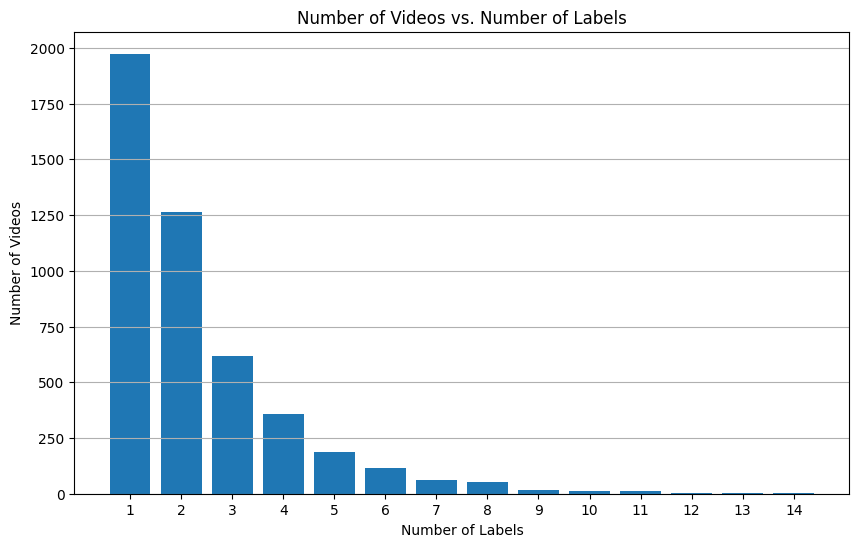

In [29]:
plot_num_videos_vs_num_labels(df)

## Processing anns for max label or single label only samples

Num labels considered -> 54


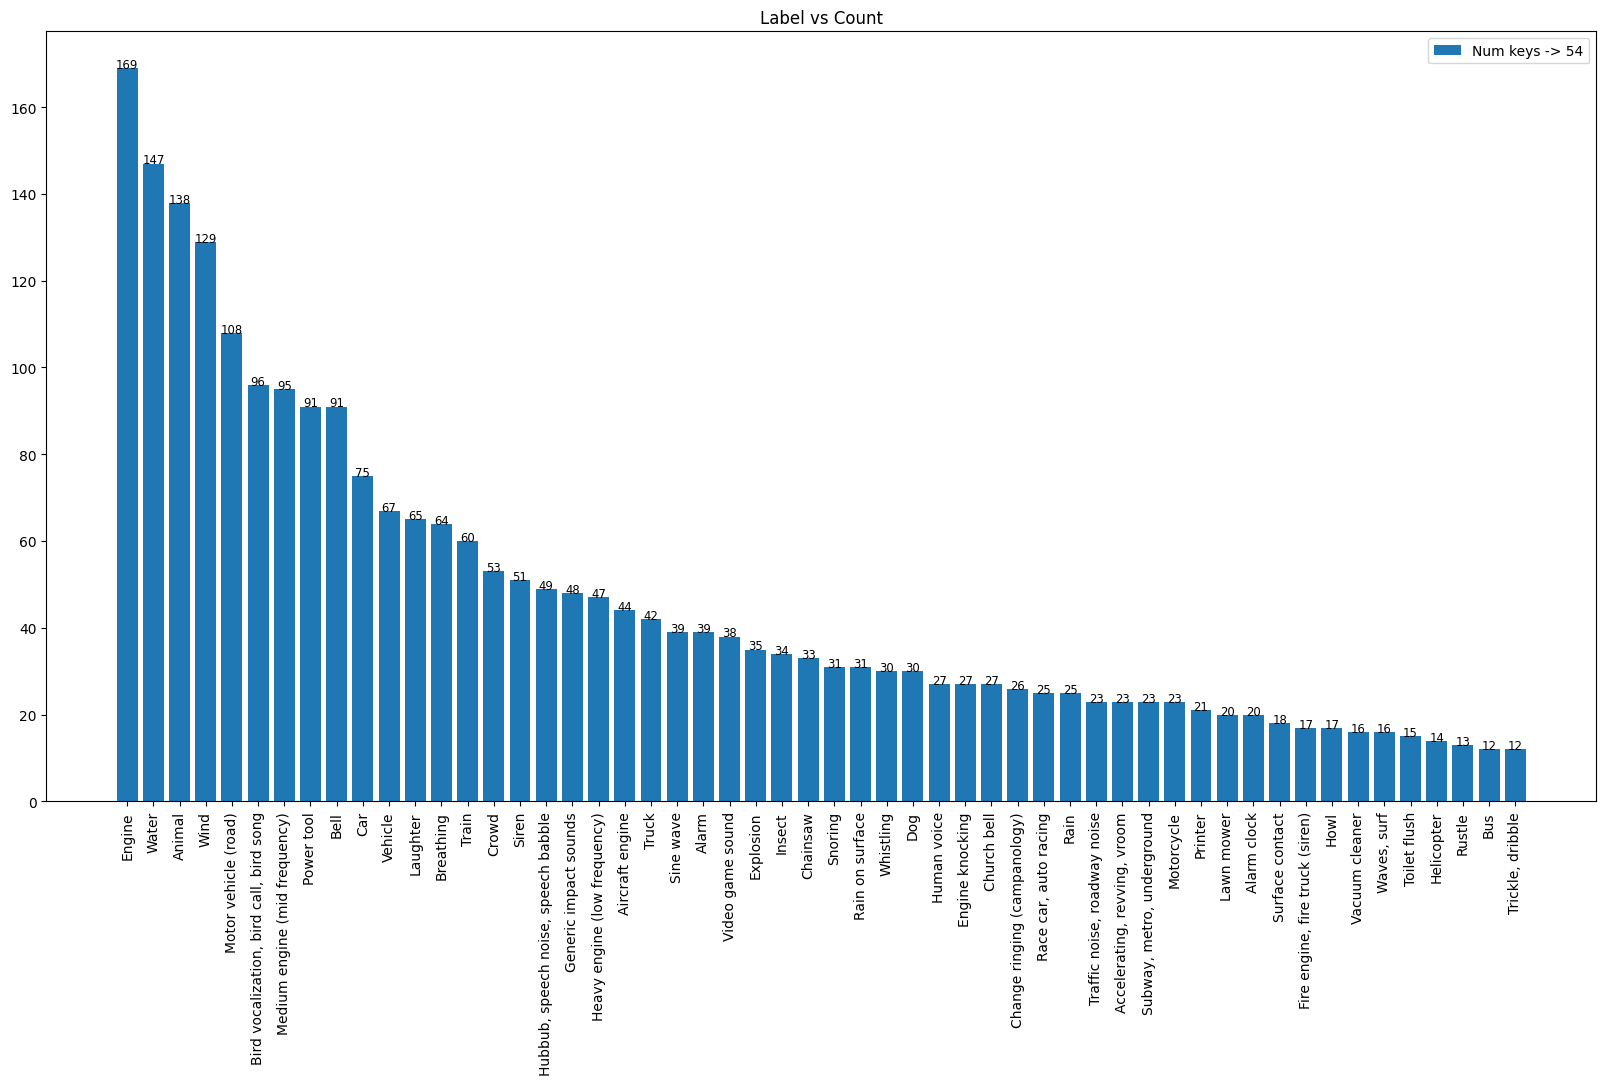

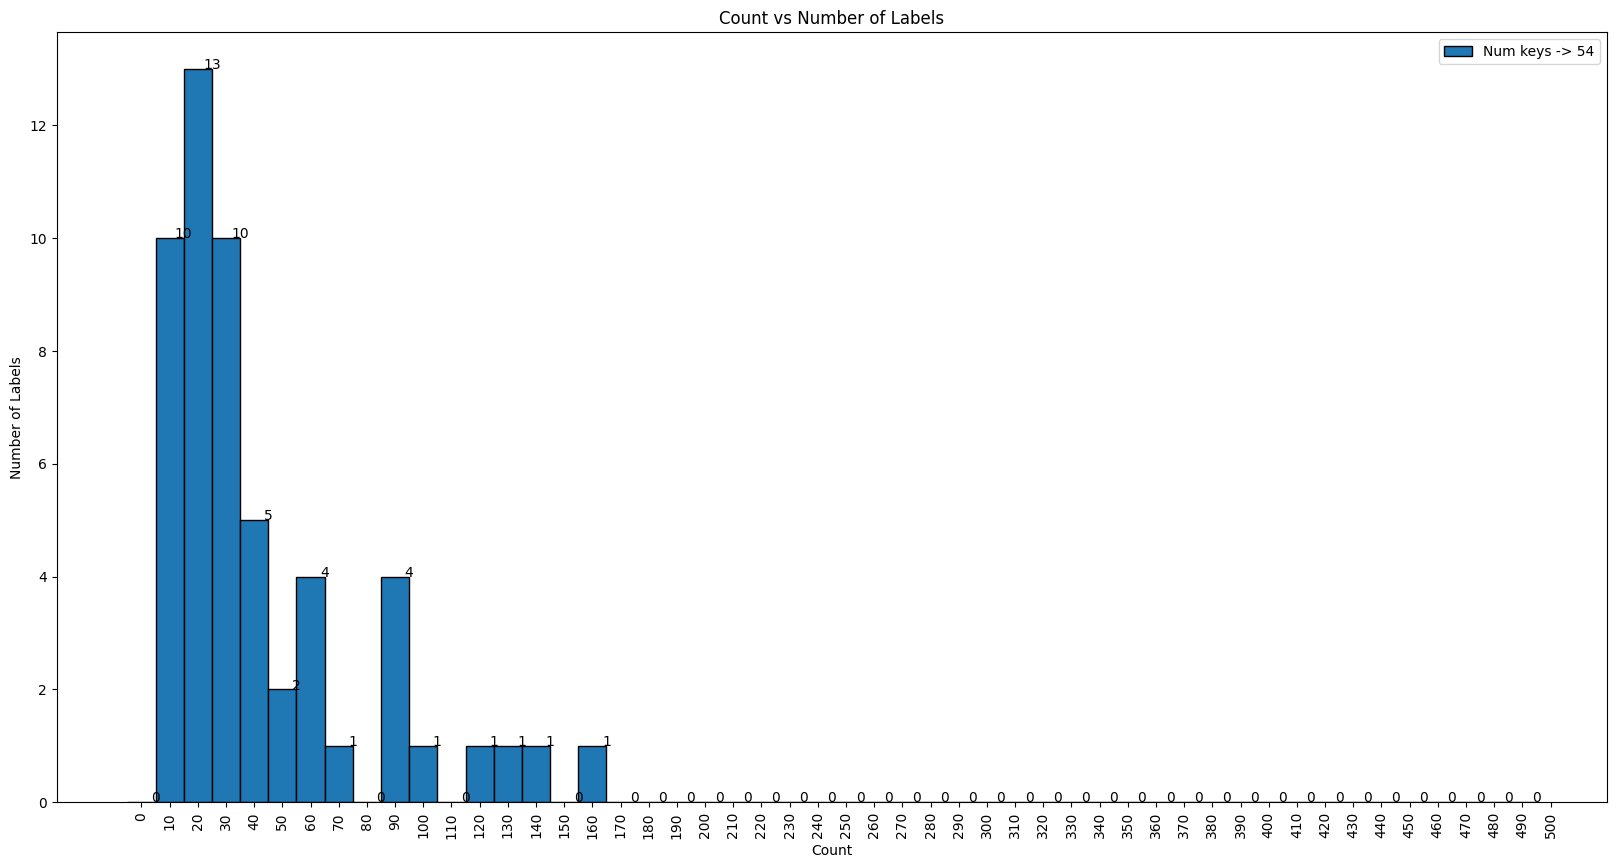

In [30]:
import numpy as np
def process_youtube_data_with_max(df, with_music=False, eval=False, labels_considered=[]):
    """
    Process YouTube data to find the label with the maximum duration for each YTID,
    and then count and print the labels in descending order of their counts.
    
    Args:
        df (pd.DataFrame): DataFrame containing YouTube segment data.
    
    Returns:
        ytid_to_label_max_duration (dict): mapping YTID to label with the maximum duration.
        label_to_count (dict): mapping label to its count.
    """
    dir = '/disk1/audioset/' + split_type+'/videos/'
    # Convert DataFrame to dictionary records
    data = df.to_dict('records')
    mids_to_avoid = [ '/m/0c1dj', '/m/093_4n', '/t/dd00077', '/m/04rlf', '/t/dd00092','/m/096m7z','/t/dd00098','/t/dd00122','/m/059j3w'] # ['Sound Effect', 'Background Noise', 'Mechanisms', 'Music','Noise', 'Source-ambiguous sounds', 'Other sourceless','Natural Sounds' ]
    # '/m/026fgl','/m/03m9d0z' -> 'Wind noise (microphone), 'Wind'
    # Initialize the dictionary to store the label with max duration for each YTID
    ytid_to_label = {}
    files_list = os.listdir(dir)
    # Iterate over each row in the data
    for row in data:
        ytid = row['YTID']
        label = row['label']
        duration = row['duration']

        # If the YTID is not in the dictionary, or if the current duration is greater than the stored one
        if (ytid not in ytid_to_label or duration > ytid_to_label[ytid]['duration'] )and not (with_music and (label in mids_to_avoid)):
            if eval and label not in labels_considered:
                continue
            ytid_to_label[ytid] = {'label': label, 'duration': duration, 'start_time': row['start_time_seconds'], 'end_time': row['end_time_seconds']}

    # Create a final dictionary with YTID to the label with the max duration
    ytid_to_label_max_duration = {ytid: value['label'] for ytid, value in ytid_to_label.items()}

    # Get label to count dictionary
    label_to_count = {}
    for ytid, label in ytid_to_label_max_duration.items():
        if label in label_to_count:
            label_to_count[label] += 1
        else:
            label_to_count[label] = 1

    # Sort the label to count dictionary by count in descending order
    label_to_count = dict(sorted(label_to_count.items(), key=lambda item: item[1], reverse=True))

    # Print the labels and their counts in descending order
    # idx = 0
    # for mid, count in label_to_count.items():
    #     idx += 1
    #     label = mid_to_label[mid_to_label['mid'] == mid]['label'].values[0]
    #     print(f'{label} ({idx}) -> {count}')

    return ytid_to_label_max_duration, label_to_count, ytid_to_label

def process_youtube_data_filtered(df, with_music=False, eval=False, labels_considered=[]):
    """
    Process YouTube data to filter out YTIDs with only one label after avoiding certain label,
    and then count and print the labels in descending order of their counts.
    
    Args:
        df (pd.DataFrame): DataFrame containing YouTube segment data.
    
    Returns:
        ytid_to_label_max_duration (dict): mapping YTID to label with the maximum duration.
        label_to_count (dict): mapping label to its count.
    """
    mids_to_avoid = ['/m/0c1dj', '/m/093_4n', '/t/dd00077', '/m/04rlf', '/t/dd00092', '/m/026fgl','/m/03m9d0z']
    
    # Filter out rows with labels to avoid
    df_filtered = df[~df['label'].isin(mids_to_avoid)]
    
    # Filter out YTIDs with only one label
    ytid_counts = df_filtered['YTID'].value_counts()
    ytids_to_include = ytid_counts[ytid_counts > 1].index
    df_filtered = df_filtered[df_filtered['YTID'].isin(ytids_to_include)]
    
    # Convert DataFrame to dictionary records
    data = df_filtered.to_dict('records')

    # Initialize the dictionary to store the label with max duration for each YTID
    ytid_to_label = {}

    # Iterate over each row in the data
    for row in data:
        ytid = row['YTID']
        label = row['label']
        duration = row['duration']

        # If the YTID is not in the dictionary, or if the current duration is greater than the stored one
        if (ytid not in ytid_to_label or duration > ytid_to_label[ytid]['duration']) and not (with_music and (label in mids_to_avoid)):
            if eval and label not in labels_considered:
                continue
            ytid_to_label[ytid] = {'label': label, 'duration': duration, 'start_time': row['start_time_seconds'], 'end_time': row['end_time_seconds']}

    # Create a final dictionary with YTID to the label with the max duration
    ytid_to_label_and_duration = {ytid: value['label'] for ytid, value in ytid_to_label.items()}

    # Get label to count dictionary
    label_to_count = {}
    for ytid, label in ytid_to_label_and_duration.items():
        if label in label_to_count:
            label_to_count[label] += 1
        else:
            label_to_count[label] = 1

    # Sort the label to count dictionary by count in descending order
    label_to_count = dict(sorted(label_to_count.items(), key=lambda item: item[1], reverse=True))

    return ytid_to_label_and_duration, label_to_count, ytid_to_label


label_selection_config_train = {
"min_num_samples_per_class" : 150,
"min_num_samples_per_for_visual_stimuli":100,
"target_num_samples" : 450
}
label_selection_config_eval = {
"min_num_samples_per_class" : 10,
"min_num_samples_per_for_visual_stimuli":10,
"target_num_samples" : 100
}

if split_type == 'train':
    label_selection_config = label_selection_config_train
    eval = False
    labels_considered = []
    
elif split_type == 'eval':
    label_selection_config = label_selection_config_eval
    eval = True
    with open('/disk1/v1/audioset/it1_audioset_labels.json', 'r') as f:
        labels_considered = json.load(f)
        print(f"Num labels considered -> {len(labels_considered)}")
    
else:
    raise NotImplementedError(f"Split type {split_type} not implemented")



# ytid_to_label_max_duration, label_to_count, ytid_to_label = process_youtube_data_filtered(df, with_music=True, eval = eval)
ytid_to_label_max_duration, label_to_count, ytid_to_label = process_youtube_data_with_max(df, with_music=True, eval = eval,labels_considered=labels_considered)

plot_label_vs_count(label_to_count, mid_to_label, label_selection_config["min_num_samples_per_class"] )

plot_percentile_label_vs_count(label_to_count, mid_to_label)

In [31]:
# In ytid_to_label keep only keys that have label with count greater than min_num_samples
ytid_to_label = {k: v for k, v in ytid_to_label.items() if label_to_count[v['label']] > label_selection_config["min_num_samples_per_class"]}
# convert ytid_to_label to DataFrame
ytid_to_label_df = pd.DataFrame.from_dict(ytid_to_label, orient='index')
ytid_to_label_df = ytid_to_label_df.reset_index()
ytid_to_label_df.columns = ['YTID', 'label','duration', 'start_time', 'end_time']
ytid_to_label_df.head()

,YTID,label,duration,start_time,end_time
0,--U7joUcTCo,/m/01j3sz,5.683,0.225,5.908
1,-0BIyqJj9ZU,/m/01j3sz,9.583,0.000,9.583
2,-1pRmoJIGQc,/t/dd00066,10.000,0.000,10.000
3,-2sE5CH8Wb8,/m/07r04,10.000,0.000,10.000
4,-3YWuPXHknk,/m/02mk9,8.224,1.776,10.000


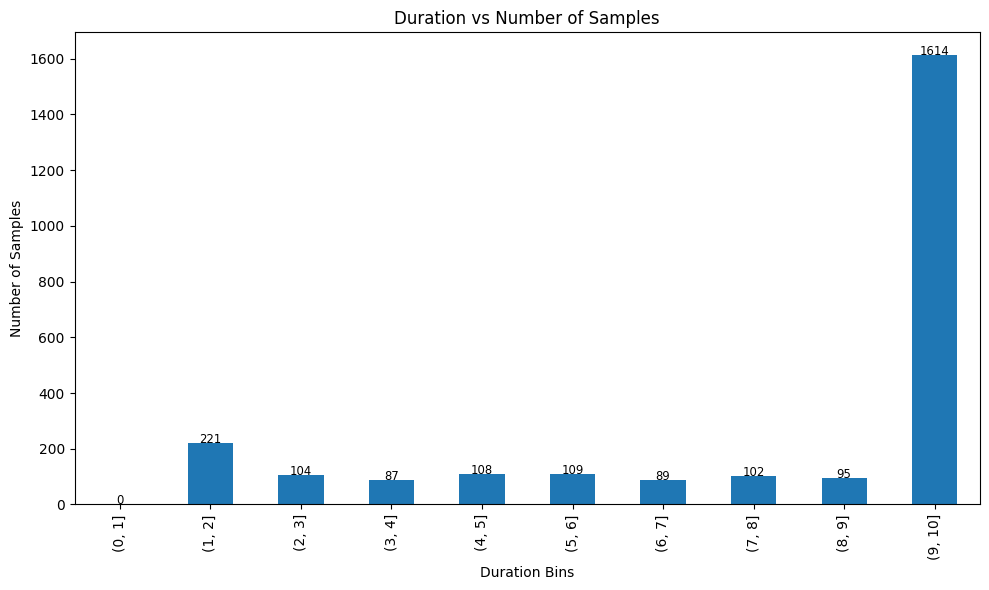

In [32]:
ytid_to_label_df = plot_binned_time_vs_num_samples(ytid_to_label_df,add_coloumn_of_probs=True)

In [33]:
# give top 20 labels in the region of 9 to 10 sec
ytid_to_label_df_9_10 = ytid_to_label_df[(ytid_to_label_df['duration'] >= 9) & (ytid_to_label_df['duration'] < 10)]
ytid_to_label_df_9_10['label'] = ytid_to_label_df_9_10['label'].apply(lambda x: mid_to_label[mid_to_label['mid']==x]['label'].values[0])
print(ytid_to_label_df_9_10['label'].value_counts().head(20))

Medium engine (mid frequency)              31
Bird vocalization, bird call, bird song    26
Engine                                     25
Animal                                     22
Water                                      21
Car                                        20
Power tool                                 18
Wind                                       18
Vehicle                                    13
Motor vehicle (road)                       11
Crowd                                      10
Sine wave                                   9
Video game sound                            8
Train                                       8
Chainsaw                                    7
Siren                                       7
Hubbub, speech noise, speech babble         7
Insect                                      7
Bell                                        6
Heavy engine (low frequency)                6
Name: label, dtype: int64


/tmp/ipykernel_2363319/2010528087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ytid_to_label_df_9_10['label'] = ytid_to_label_df_9_10['label'].apply(lambda x: mid_to_label[mid_to_label['mid']==x]['label'].values[0])


In [16]:
ytid_to_label_df.head()

,YTID,label,duration,start_time,end_time,binned_duration,prbs_with_duration,is_present
0,--U7joUcTCo,/m/01j3sz,5.683,0.225,5.908,"(5, 6]",1.000000e-09,False
1,-0BIyqJj9ZU,/m/01j3sz,9.583,0.000,9.583,"(9, 10]",1.000000e-09,False
2,-1pRmoJIGQc,/t/dd00066,10.000,0.000,10.000,"(9, 10]",1.000000e-09,False
3,-2sE5CH8Wb8,/m/07r04,10.000,0.000,10.000,"(9, 10]",1.000000e-09,False
4,-3YWuPXHknk,/m/02mk9,8.224,1.776,10.000,"(8, 9]",1.000000e-09,False


In [34]:
# save df to json
ytid_to_label_df.to_json(f'/disk1/v1/audioset/audioset_anns_{split_type}.json', orient='records')

### LOAD ABOVE FILE FOR FURTHER ANALYSIS

In [35]:
import pandas as pd
import os
import numpy as np

with open(f'/disk1/v1/audioset/audioset_anns_{split_type}.json', 'r') as f:
    ytid_to_label_df = pd.read_json(f)
ytid_to_label_df.head()

,YTID,label,duration,start_time,end_time,binned_duration,prbs_with_duration,is_present
0,--U7joUcTCo,/m/01j3sz,5.683,0.225,5.908,"{'closed': 'right', 'closed_left': False, 'clo...",1.000000e-09,False
1,-0BIyqJj9ZU,/m/01j3sz,9.583,0.000,9.583,"{'closed': 'right', 'closed_left': False, 'clo...",1.000000e-09,False
2,-1pRmoJIGQc,/t/dd00066,10.000,0.000,10.000,"{'closed': 'right', 'closed_left': False, 'clo...",1.000000e-09,False
3,-2sE5CH8Wb8,/m/07r04,10.000,0.000,10.000,"{'closed': 'right', 'closed_left': False, 'clo...",1.000000e-09,False
4,-3YWuPXHknk,/m/02mk9,8.224,1.776,10.000,"{'closed': 'right', 'closed_left': False, 'clo...",1.000000e-09,False


## Making final dataset and samples selected for dataset to mix with People's speech

### consider for more label skew handling without compramising on the number of unique samples by selecting some samples without repitition first and then selecting the rest with repitition

In [36]:

samples_per_class = label_selection_config["target_num_samples"]
final_anns = pd.DataFrame()
all_labels = ytid_to_label_df['label'].unique()

for label in all_labels:
    df = ytid_to_label_df[ytid_to_label_df['label'] == label]
    if len(df) > samples_per_class:
        # Sample without replacement when enough samples are available
        df = df.sample(samples_per_class, weights=df['prbs_with_duration'], replace=False, random_state=42)
    else:
        # Ensure at least N unique samples
        unique_samples = df.sample(min(len(df), label_selection_config["min_num_samples_per_for_visual_stimuli"]), weights=df['prbs_with_duration'], replace=False, random_state=42)

        # Sample the remaining samples with replacement to reach the required number
        additional_samples_needed = samples_per_class - len(unique_samples)
        if additional_samples_needed > 0:
            additional_samples = df.sample(additional_samples_needed, weights=df['prbs_with_duration'], replace=True, random_state=42)
            df = pd.concat([unique_samples, additional_samples])
        else:
            df = unique_samples
    final_anns = pd.concat([final_anns, df])

final_anns.reset_index(drop=True, inplace=True)
print(len(final_anns))
# save final_anns to json
final_anns.to_json(f'/disk1/v1/audioset/audioset_anns_final_{split_type}.json', orient='records')

5400


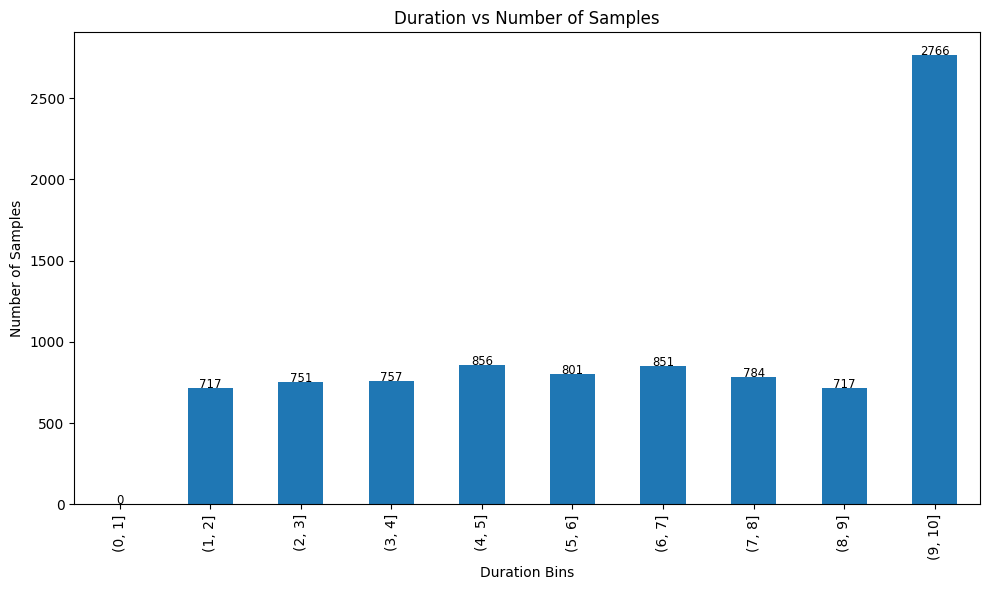

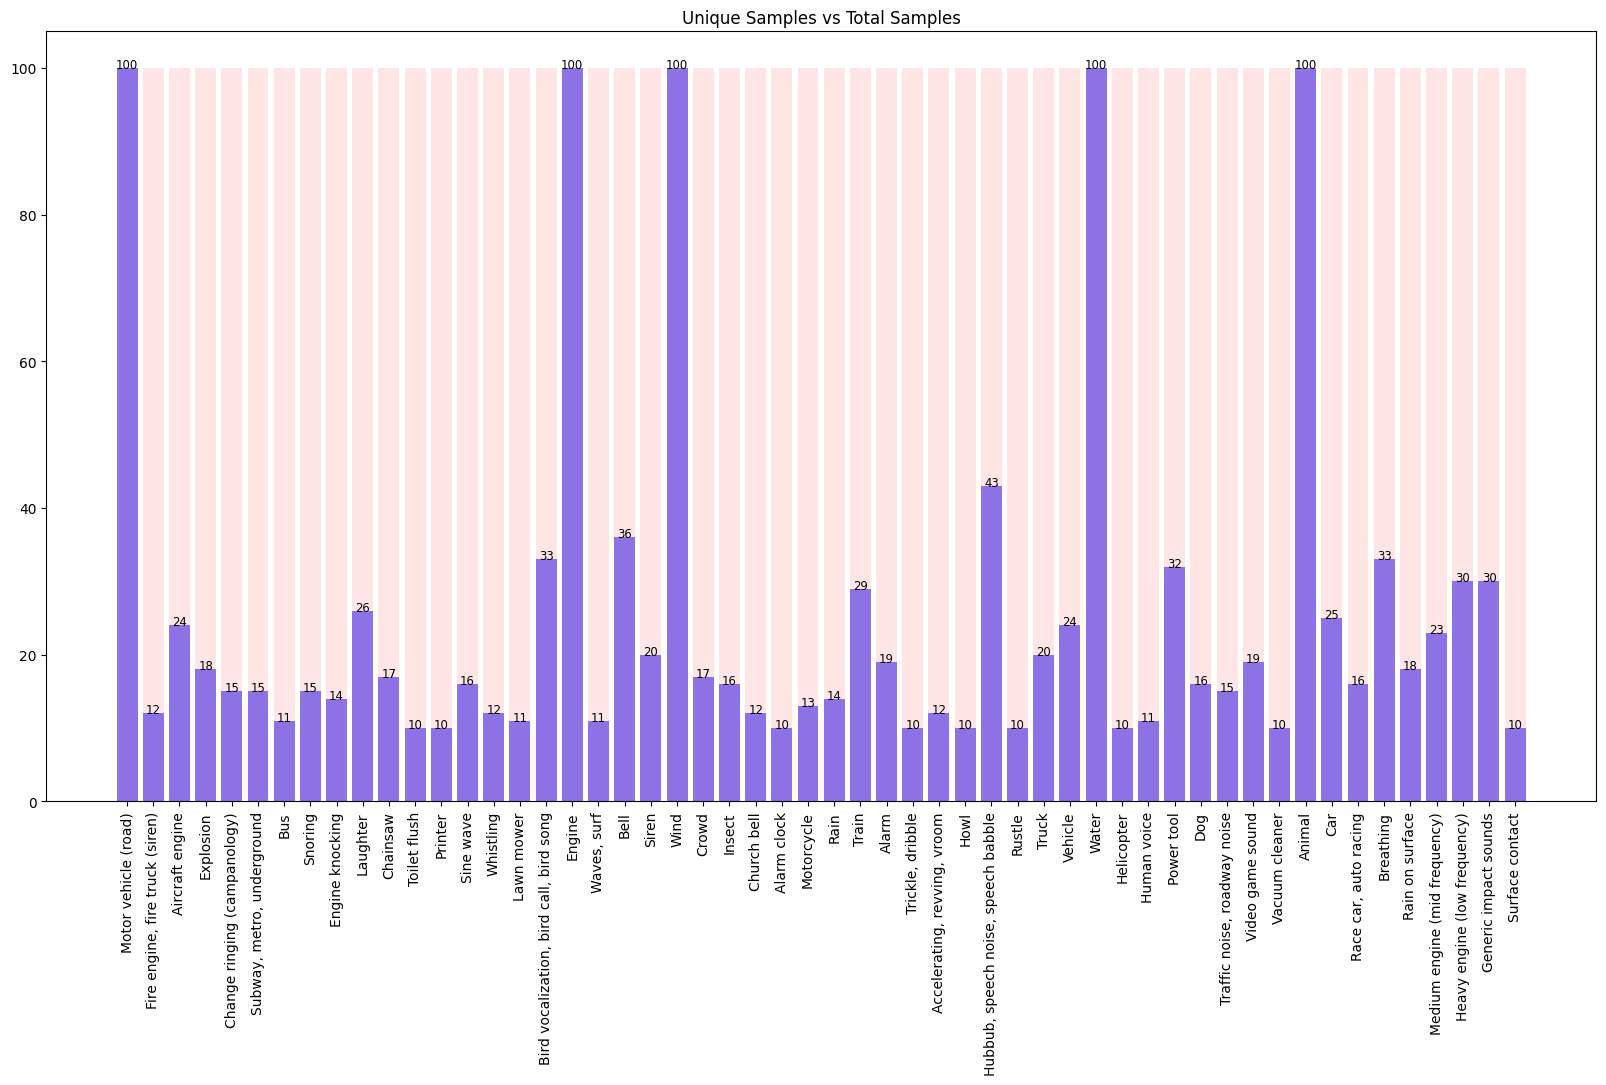

In [39]:
plot_binned_time_vs_num_samples(final_anns,add_coloumn_of_probs=False)
def plot_unique_samples_vs_total_samples(df):
    label_to_count = df['label'].value_counts()
    label_to_unique_count = df.groupby('label')['YTID'].nunique()
    plt.figure(figsize=(20, 10))
    # use mid_to_label to convert mid to label
    label_to_unique_count = {mid_to_label[mid_to_label['mid'] == k]['label'].values[0]: v for k, v in label_to_unique_count.items()}
    label_to_count = {mid_to_label[mid_to_label['mid'] == k]['label'].values[0]: v for k, v in label_to_count.items()}
    plt.bar(label_to_unique_count.keys(), label_to_unique_count.values(), color='b', alpha=0.5)
    # keep counts on top of bar
    for i, v in enumerate(label_to_unique_count.values()):
        plt.text(i, v, str(v), ha='center', fontsize='small')
    plt.bar(label_to_count.keys(), label_to_count.values(), color='r', alpha=0.1)
    plt.title('Unique Samples vs Total Samples')
    # x labels are rotated by 90 degrees for readability
    plt.xticks(rotation=90)
    plt.show()

mid_to_label = pd.read_csv('/disk1/audioset/annotations/mid_to_display_name.tsv', sep='\t', names=['mid', 'label'])
final_anns = pd.read_json(f'/disk1/v1/audioset/audioset_anns_final_{split_type}.json')
plot_unique_samples_vs_total_samples(final_anns)


In [40]:
import json
labels_list = final_anns['label'].unique()
print(f"Num labels -> {len(labels_list)}")
# save it as json
with open('/disk1/v1/audioset/it1_audioset_labels.json', 'w') as f:
    json.dump(labels_list.tolist(), f)

Num labels -> 54


## LOADING ABOVE FINAL AUDIOSET ANNOTATION FOR DOWNLOADS ANALYSIS

In [42]:
import json
import pandas as pd
import os
config = {
    "file": f'/disk1/v1/audioset/audioset_anns_final_{split_type}.json',
    "file_with_audioset_info": f'/disk1/audioset/annotations/audioset_{split_type}_strong.csv',
    "videos_dir": f'/disk1/audioset/{split_type}/videos',
    "feats_dir": f'/disk1/audioset/{split_type}/feats_ViT-B-32_5fps',
    "as_info_file": f"/disk1/audioset/{split_type}/info.json",
}
videos_list = os.listdir(config["videos_dir"])
feats_list = os.listdir(config["feats_dir"])
feats_list = [f.split('.')[0] for f in feats_list]
videos_list = [f.split('.')[0] for f in videos_list]
# get intersection of videos_list and feats_list
videos_list = set(videos_list).intersection(set(feats_list))
as_info = json.load(open(config["as_info_file"], 'r'))
no_issue_videos = []
for vid in as_info.keys():
    if as_info[vid]['has_video'] and as_info[vid]['has_audio']:
        no_issue_videos.append(vid.split('/')[-1].split('.')[0])
videos_list = set(videos_list).intersection(set(no_issue_videos))
data = {}
with open(config['file'], 'r') as f:
    data = json.load(f)

count = 0
missing_count = 0
# make unique set of ann['YTID'] and check if it is in videos_list
df_with_audioset_info = pd.read_csv(config['file_with_audioset_info'])
missing_df = pd.DataFrame()
all_ytids = set([ann['YTID'] for ann in data])
for vid in all_ytids:
    video_id_al_num = ''.join(e for e in vid if e.isalnum())
    if video_id_al_num in videos_list:
        count += 1
    else:
        missing_count += 1
        # find the row with YTID in df_with_audioset_info after doing df_with_audioset_info -> YTIDs with only alnum
        missing_df = pd.concat([missing_df, df_with_audioset_info[df_with_audioset_info['YTID'] == vid]])

print(count, missing_count)

# save missing_df to csv
# missing_df.to_csv('/disk1/audioset/annotations/missing_files_{split_type}.csv', index=False)

1233 150


In [43]:
# give a plot based on final anns with only videos that are present (videos_list)
final_anns['parsed_YTID'] = final_anns['YTID'].apply(lambda vid: ''.join(e for e in vid if e.isalnum()))
final_anns_present = final_anns[final_anns['parsed_YTID'].isin(videos_list)]
final_anns_present.reset_index(drop=True, inplace=True)
final_anns_present.head()

,YTID,label,duration,start_time,end_time,binned_duration,prbs_with_duration,is_present,parsed_YTID
0,EQMKpWLxavE,/m/01j3sz,1.804,5.677,7.481,"{'closed': 'right', 'closed_left': False, 'clo...",11.443439,True,EQMKpWLxavE
1,wdPWomHjCx8,/m/01j3sz,2.857,0.816,3.673,"{'closed': 'right', 'closed_left': False, 'clo...",24.317308,True,wdPWomHjCx8
2,TEYK6ZUCB28,/m/01j3sz,1.244,5.780,7.024,"{'closed': 'right', 'closed_left': False, 'clo...",11.443439,True,TEYK6ZUCB28
3,MaG2BHKuTD8,/m/01j3sz,4.835,5.165,10.000,"{'closed': 'right', 'closed_left': False, 'clo...",23.416667,True,MaG2BHKuTD8
4,75bMAERnvng,/m/01j3sz,1.094,7.158,8.252,"{'closed': 'right', 'closed_left': False, 'clo...",11.443439,True,75bMAERnvng


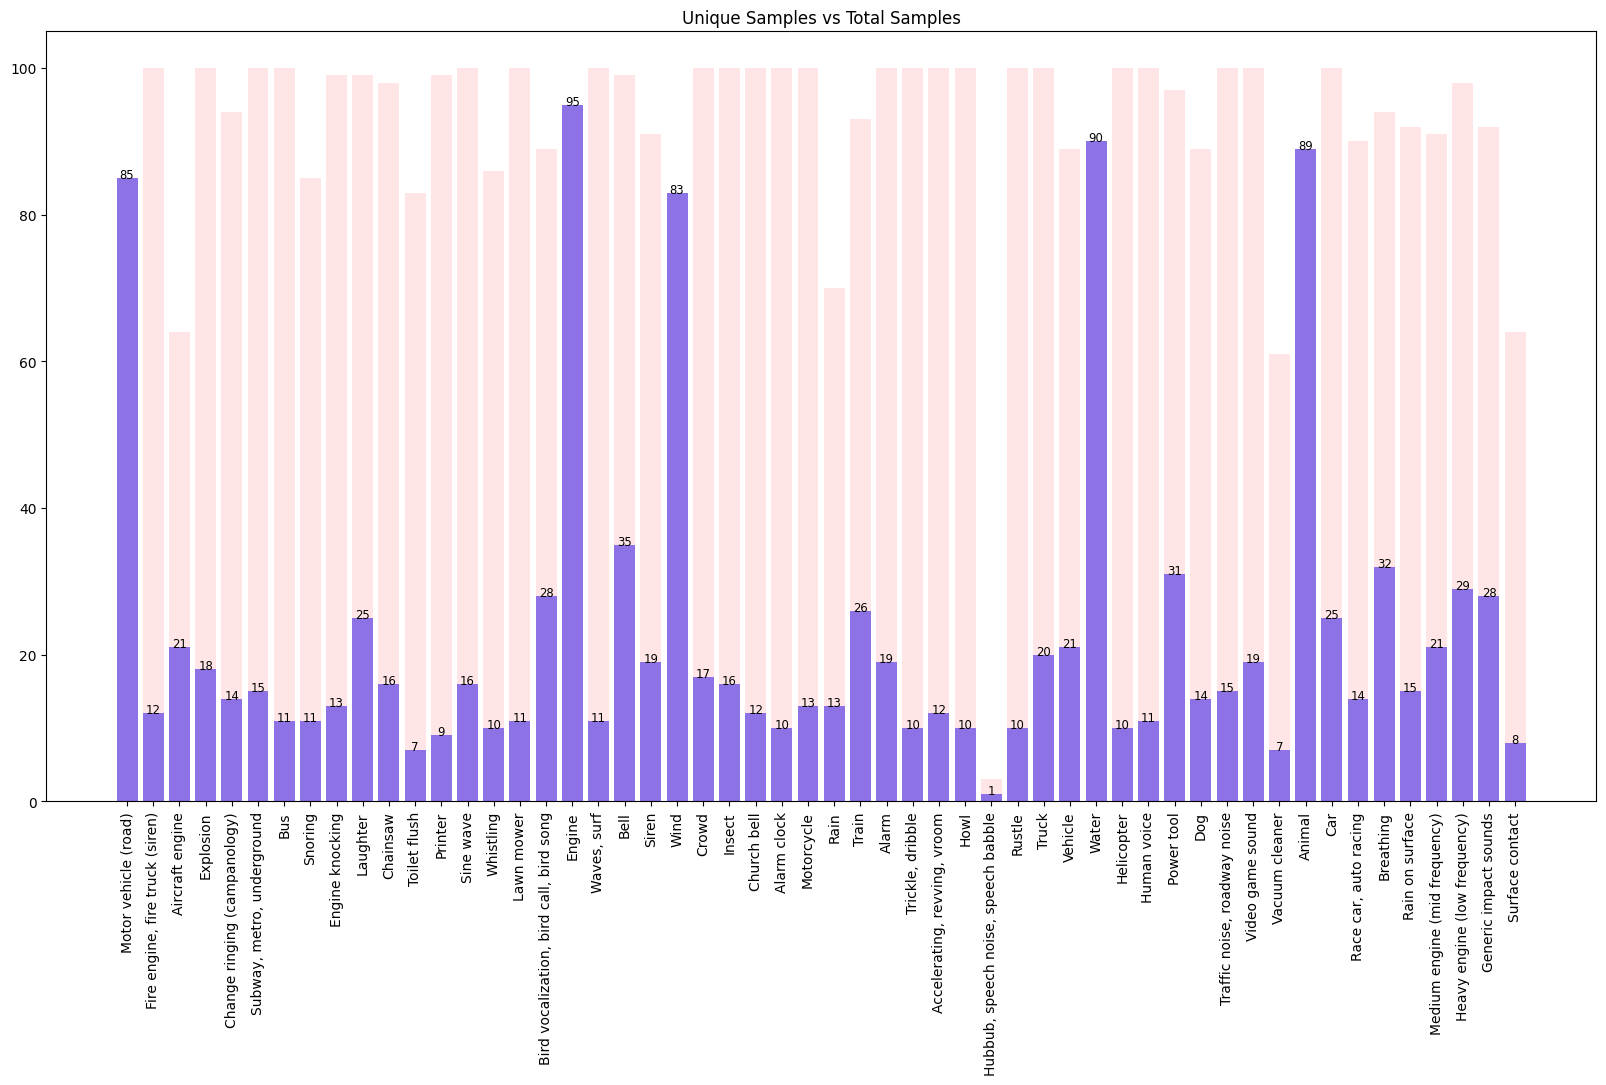

In [44]:
# plot_binned_time_vs_num_samples(final_anns_present,add_coloumn_of_probs=False)
plot_unique_samples_vs_total_samples(final_anns_present)
final_anns_present.to_json(f'/disk1/v1/audioset/audioset_anns_final_{split_type}_present.json', orient='records')